In [7]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from battery import Battery


# Load the data into the variable DF
df=pd.read_csv('PV_raw_data.csv')

capacities = range(12, 121)  # from 12 to 120 in steps of 1

import warnings
warnings.filterwarnings('ignore')

results_1 = []

for capacity in capacities:
    #drop data points that have zero ac output
    df_cleaned=df.copy()
    #drop unneeded comlumns
    df_cleaned.drop(columns=['Beam Irradiance (W/m2)',
                        'Diffuse Irradiance (W/m2)',
                        'Ambient Temperature (C)',
                        'Wind Speed (m/s)', 
                        'Plane of Array Irradiance (W/m2)', 
                        'Cell Temperature (C)',
                        'DC Array Output (W)', 
                        'Albedo'
                        ], inplace=True)
    #Transform the DF into datetime
    df_cleaned['year'] = 2023
   

    # Create a datetime column
    df_cleaned['datetime'] = pd.to_datetime(df_cleaned[['year', 'Month', 'Day', 'Hour']])
    
    # Set datetime as the index
    df_cleaned.set_index('datetime', inplace=True)
    
    
        #Set some parameters :
    min_energy_consumption = 6
    max_energy_consumption = 100

    
    #Create some Series to save data in and join to the main data frame later:
    energy_consumption_battery=pd.Series(0,index=df_cleaned.index)
    energy_consumption_no_battery=pd.Series(0,index=df_cleaned.index)
    excess_energy=pd.Series(0,index=df_cleaned.index)
    Battery_charge=pd.Series(0,index=df_cleaned.index)
    
    
    # Create the battery with the current capacity
    Battery_12MW_XMWh = Battery(power_capacity=12, energy_capacity=capacity, efficiency=1)    
    #convert AC power output into MWh
    df_cleaned['Energy Generated (MWh)']=df_cleaned['AC System Output (W)']*0.000001
    df['Energy Generated (MWh)']=df['AC System Output (W)']*0.000001


    for date,ac_output_mwh in df_cleaned['Energy Generated (MWh)'].items():
        Battery_charge[date]=Battery_12MW_XMWh.get_charge()
        
        if ac_output_mwh > min_energy_consumption: #minimum to enter the grid
            
            if ac_output_mwh > max_energy_consumption: #maximum to enter the grid
                
                # set energy consumption to max
                energy_consumption_battery[date] = max_energy_consumption
                energy_consumption_no_battery[date]=max_energy_consumption
                
                # find the excess energy 
                excess_energy[date]=ac_output_mwh-max_energy_consumption
                
                # charge the battery with the excess energy
                # the battery will only charge according to the power_capacity
                Battery_12MW_XMWh.charge(power=excess_energy[date]) 
                
            else: # energy is within the max and min
            
                energy_consumption_battery[date] = ac_output_mwh
                energy_consumption_no_battery[date]=ac_output_mwh
                
        else: # energy less than min
            
            if Battery_12MW_XMWh.get_charge() > min_energy_consumption: # to make sure that we dont discharge power that wont be enough to power the grid
                energy_consumption_battery[date] = Battery_12MW_XMWh.discharge(power=12-ac_output_mwh) + ac_output_mwh
            energy_consumption_no_battery[date]=0
            
        if energy_consumption_battery[date] <= min_energy_consumption: # when no energy is left in the battery, and energy is less than min
            Battery_12MW_XMWh.charge(power=ac_output_mwh)
            energy_consumption_battery[date] = 0

    # Explicitly set any 0 values to NaN if needed
    energy_consumption_battery.replace(0, np.nan, inplace=True)
    energy_consumption_no_battery.replace(0, np.nan, inplace=True)
    df_cleaned.replace(0, np.nan, inplace=True)

    # Drop NaN values
    energy_consumption_battery_cleaned = energy_consumption_battery.dropna()
    energy_consumption_no_battery_cleaned = energy_consumption_no_battery.dropna()

    energy_consumption_battery.replace(np.nan, 0, inplace=True)
    energy_consumption_no_battery.replace(np.nan, 0, inplace=True)
    
    energy_consumption_cleaned_month=energy_consumption_battery_cleaned.resample('M').sum()
    energy_consumption_no_battery_cleaned_month=energy_consumption_no_battery_cleaned.resample('M').sum()
    energy_difference=energy_consumption_cleaned_month - energy_consumption_no_battery_cleaned_month


    print (f"the total yearly energy stored by the {capacity} MWh battery is {energy_difference.sum()} MWh")
    results_1.append(energy_difference.sum())


df_energy_1=pd.concat([df_cleaned,energy_consumption_no_battery,excess_energy,Battery_charge,energy_consumption_battery],axis=1)
df_new=pd.concat([df,energy_consumption_no_battery,excess_energy,Battery_charge,energy_consumption_battery],axis=1)

df_new.rename(columns={0:'Energy Consumption (no battery)',1:'Excess Energy',2:'Battery Charge',3: 'Energy Consumption Battery'},errors="raise",inplace=True)
df_energy_1.rename(columns={0:'Energy Consumption (no battery)',1:'Excess Energy',2:'Battery Charge',3: 'Energy Consumption Battery'},errors="raise",inplace=True)



            

the total yearly energy stored by the 12 MWh battery is 3208.565264664001 MWh
the total yearly energy stored by the 13 MWh battery is 3261.070508705003 MWh
the total yearly energy stored by the 14 MWh battery is 3310.1601316160068 MWh
the total yearly energy stored by the 15 MWh battery is 3408.452946947007 MWh
the total yearly energy stored by the 16 MWh battery is 3471.5095417230077 MWh
the total yearly energy stored by the 17 MWh battery is 3593.717527472003 MWh
the total yearly energy stored by the 18 MWh battery is 3997.0298499050077 MWh
the total yearly energy stored by the 19 MWh battery is 4913.744803583002 MWh
the total yearly energy stored by the 20 MWh battery is 5134.019251659003 MWh
the total yearly energy stored by the 21 MWh battery is 5350.071809057001 MWh
the total yearly energy stored by the 22 MWh battery is 5561.149874336999 MWh
the total yearly energy stored by the 23 MWh battery is 5759.909102628006 MWh
the total yearly energy stored by the 24 MWh battery is 5945.

# ChatGPT code 

C:\Users\alyou\AppData\Local\Temp\ipykernel_8956\2290340294.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.264380753999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Battery_charge[date] = Battery_12MW_XMWh.get_charge()
C:\Users\alyou\AppData\Local\Temp\ipykernel_8956\2290340294.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.7548438' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  energy_consumption_battery[date] = ac_output_mwh
C:\Users\alyou\AppData\Local\Temp\ipykernel_8956\2290340294.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.7548438' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
 

the total yearly energy stored by the 12 MWh battery is 3208.565264664001 MWh
the total yearly energy stored by the 13 MWh battery is 3261.070508705003 MWh
the total yearly energy stored by the 14 MWh battery is 3310.1601316160068 MWh
the total yearly energy stored by the 15 MWh battery is 3408.452946947007 MWh
the total yearly energy stored by the 16 MWh battery is 3471.5095417230077 MWh
the total yearly energy stored by the 17 MWh battery is 3593.717527472003 MWh
the total yearly energy stored by the 18 MWh battery is 3997.0298499050077 MWh
the total yearly energy stored by the 19 MWh battery is 4913.744803583002 MWh
the total yearly energy stored by the 20 MWh battery is 5134.019251659003 MWh
the total yearly energy stored by the 21 MWh battery is 5350.071809057001 MWh
the total yearly energy stored by the 22 MWh battery is 5561.149874336999 MWh
the total yearly energy stored by the 23 MWh battery is 5759.909102628006 MWh
the total yearly energy stored by the 24 MWh battery is 5945.

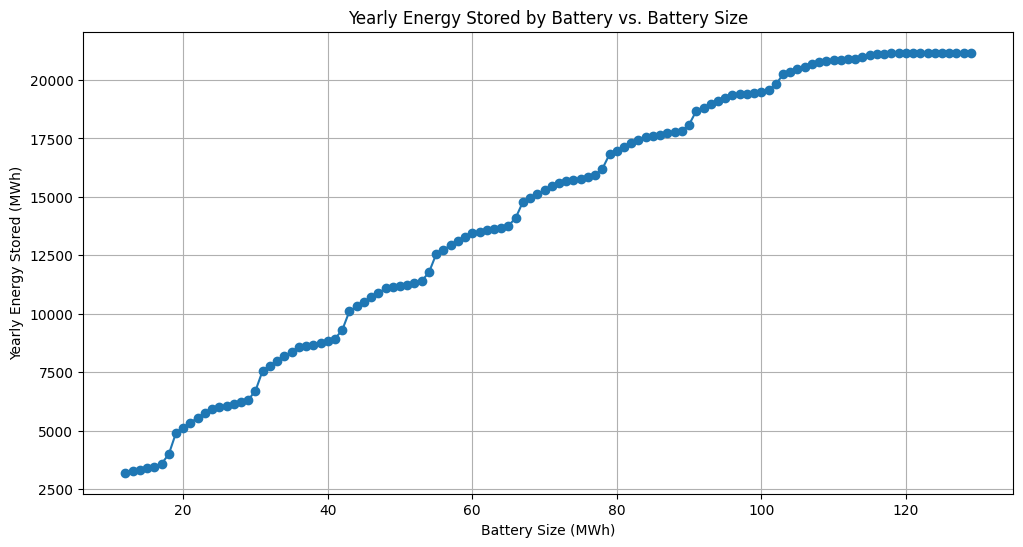

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from battery import Battery


# Load the data into the variable DF
df = pd.read_csv('Data Analysis\PV_raw_data.csv')

# Drop data points that have zero AC output and unneeded columns
df_cleaned = df.copy()
df_cleaned.drop(columns=['Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)', 
                         'Ambient Temperature (C)', 'Wind Speed (m/s)', 
                         'Plane of Array Irradiance (W/m2)', 'Cell Temperature (C)', 
                         'DC Array Output (W)', 'Albedo'], inplace=True)

# Transform the DF into datetime
df_cleaned['year'] = 2023
df_cleaned['datetime'] = pd.to_datetime(df_cleaned[['year', 'Month', 'Day', 'Hour']])
df_cleaned.set_index('datetime', inplace=True)
df_cleaned.drop(columns=['Month', 'Day', 'Hour', 'year'], inplace=True)

# Convert AC power output into MWh
df_cleaned['Energy Generated (MWh)'] = df_cleaned['AC System Output (W)'] * 0.000001

# Set some parameters
min_energy_consumption = 6
max_energy_consumption = 100

# Create lists to store results
battery_sizes = list(range(12, 121, 1))
yearly_energy_stored = []

# Loop through different battery sizes and calculate the yearly energy stored
# for energy_capacity in battery_sizes:
#     Battery_12MW_XMWh = Battery(power_capacity=12, energy_capacity=energy_capacity, efficiency=1)
    
#     # Create Series to save data in and join to the main data frame later
#     energy_consumption_battery = pd.Series(0, index=df_cleaned.index)
#     energy_consumption_no_battery = pd.Series(0, index=df_cleaned.index)
#     excess_energy = pd.Series(0, index=df_cleaned.index)
#     Battery_charge = pd.Series(0, index=df_cleaned.index)
    
#     for date, ac_output_mwh in df_cleaned['Energy Generated (MWh)'].items():
#         Battery_charge[date] = Battery_12MW_XMWh.get_charge()
#         if ac_output_mwh > min_energy_consumption:  # Minimum to enter the grid
#             if ac_output_mwh > max_energy_consumption:  # Maximum to enter the grid
#                 energy_consumption_battery[date] = max_energy_consumption
#                 energy_consumption_no_battery[date] = max_energy_consumption
#                 excess_energy[date] = ac_output_mwh - max_energy_consumption
#                 Battery_12MW_XMWh.charge(power=excess_energy[date]) 
#             else:  # Energy is within the max and min
#                 energy_consumption_battery[date] = ac_output_mwh
#                 energy_consumption_no_battery[date] = ac_output_mwh
#         else:  # Energy less than min
#             if Battery_12MW_XMWh.get_charge() > min_energy_consumption:
#                 energy_consumption_battery[date] = Battery_12MW_XMWh.discharge(power=12-ac_output_mwh) + ac_output_mwh
#             energy_consumption_no_battery[date] = 0
#         if energy_consumption_battery[date] <= min_energy_consumption:
#             Battery_12MW_XMWh.charge(power=ac_output_mwh)
#             energy_consumption_battery[date] = 0

#     # Explicitly set any 0 values to NaN if needed
#     energy_consumption_battery.replace(0, np.nan, inplace=True)
#     energy_consumption_no_battery.replace(0, np.nan, inplace=True)
    
#     # Drop NaN values
#     energy_consumption_battery_cleaned = energy_consumption_battery.dropna()
#     energy_consumption_no_battery_cleaned = energy_consumption_no_battery.dropna()
    
#     # Calculate energy differences
#     energy_consumption_cleaned_month = energy_consumption_battery_cleaned.resample('M').sum()
#     energy_consumption_no_battery_cleaned_month = energy_consumption_no_battery_cleaned.resample('M').sum()
#     energy_difference = energy_consumption_cleaned_month - energy_consumption_no_battery_cleaned_month
    
#     # Sum the yearly energy stored
#     yearly_energy_stored.append(energy_difference.sum())

# print(yearly_energy_stored)
# # Plot the yearly energy stored for different battery sizes
# plt.figure(figsize=(12, 6))
# plt.plot(battery_sizes, yearly_energy_stored, marker='o')
# plt.title('Yearly Energy Stored by Battery vs. Battery Size')
# plt.xlabel('Battery Size (MWh)')
# plt.ylabel('Yearly Energy Stored (MWh)')
# plt.grid(True)
# plt.show()

# Create a heat map of power vs. energy capacity
power_capacities = list(range(7, 24))  # Assuming power capacity ranges from 1MW to 12MW
energy_capacities = range(10,130,10)

heat_map_data = np.zeros((len(power_capacities), len(energy_capacities)))

for i, power_capacity in enumerate(power_capacities):
    for j, energy_capacity in enumerate(energy_capacities):
        Battery_XMW_XMWh = Battery(power_capacity=power_capacity, energy_capacity=energy_capacity, efficiency=1)
        
        # Reset data for the new battery configuration
        energy_consumption_battery = pd.Series(0, index=df_cleaned.index)
        energy_consumption_no_battery = pd.Series(0, index=df_cleaned.index)
        excess_energy = pd.Series(0, index=df_cleaned.index)
        Battery_charge = pd.Series(0, index=df_cleaned.index)
        
        for date, ac_output_mwh in df_cleaned['Energy Generated (MWh)'].items():
            Battery_charge[date] = Battery_XMW_XMWh.get_charge()
            if ac_output_mwh > min_energy_consumption:
                if ac_output_mwh > max_energy_consumption:
                    energy_consumption_battery[date] = max_energy_consumption
                    energy_consumption_no_battery[date] = max_energy_consumption
                    excess_energy[date] = ac_output_mwh - max_energy_consumption
                    Battery_XMW_XMWh.charge(power=excess_energy[date])
                else:
                    energy_consumption_battery[date] = ac_output_mwh
                    energy_consumption_no_battery[date] = ac_output_mwh
            else:
                if Battery_XMW_XMWh.get_charge() > min_energy_consumption:
                    energy_consumption_battery[date] = Battery_XMW_XMWh.discharge(power=power_capacity-ac_output_mwh) + ac_output_mwh
                energy_consumption_no_battery[date] = 0
            if energy_consumption_battery[date] <= min_energy_consumption:
                Battery_XMW_XMWh.charge(power=ac_output_mwh)
                energy_consumption_battery[date] = 0
        
        energy_consumption_battery.replace(0, np.nan, inplace=True)
        energy_consumption_no_battery.replace(0, np.nan, inplace=True)
        
        energy_consumption_battery_cleaned = energy_consumption_battery.dropna()
        energy_consumption_no_battery_cleaned = energy_consumption_no_battery.dropna()
        
        energy_consumption_cleaned_month = energy_consumption_battery_cleaned.resample('ME').sum()
        energy_consumption_no_battery_cleaned_month = energy_consumption_no_battery_cleaned.resample('ME').sum()
        energy_difference = energy_consumption_cleaned_month - energy_consumption_no_battery_cleaned_month
        
        heat_map_data[i, j] = energy_difference.sum()
    
   
# Plot the heat map
plt.figure(figsize=(12, 6))
plt.imshow(heat_map_data, cmap='hot_r', interpolation='nearest', aspect='auto')
plt.colorbar(label='Yearly Energy Stored (MWh)')
plt.title('Heat Map of Yearly Energy Stored by Battery')
plt.xlabel('Energy Capacity (MWh)')
plt.ylabel('Power Capacity (MW)')
plt.xticks(ticks=np.arange(len(energy_capacities)), labels=energy_capacities)
plt.yticks(ticks=np.arange(len(power_capacities)), labels=power_capacities)
plt.show()
